### Part 1: CNN

Use the dataset: https://www.tensorflow.org/datasets/catalog/citrus_leaves 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
!pip install tfds-nightly

     |████████████████████████████████| 3.9MB 15.8MB/s 


In [ ]:
# Loading data
ds, info = tfds.load('citrus_leaves', split='train', with_info=True, as_supervised= True)



In [ ]:
data = tfds.as_dataframe(ds, info) # Converting data to dataframe

In [ ]:
data.head()

,image,label
0,"[[[217, 202, 203], [218, 202, 204], [220, 204,...",1
1,"[[[219, 220, 225], [220, 221, 226], [220, 221,...",3
2,"[[[190, 188, 203], [156, 152, 176], [160, 156,...",2
3,"[[[162, 158, 174], [163, 159, 176], [163, 159,...",2
4,"[[[188, 180, 187], [188, 180, 187], [188, 179,...",1


In [ ]:
data.shape

(594, 3)

Split it into a training set, and a test set.

In [ ]:
#Split data using String API 
# train[:70%] selects first 70% data into ds_train
# train[80%:] selects last 20% data into ds_test
(ds_train, ds_val, ds_test), metadata = tfds.load(
    'citrus_leaves',
    split=['train[:70%]', 'train[70%:80%]', 'train[80%:]'],
    with_info=True,
)

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


In [ ]:
metadata.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
})

In [ ]:
ds, info = tfds.load('citrus_leaves', split='train', with_info=True, as_supervised= True)

In [ ]:
#Normalising Images

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
#Data Augmentation technique from tensorflow documentation is used. 
#Data augmentation is a technique to artificially create new training data from existing training data. It helps  to increase the size of the dataset and introduce variability in the dataset, without actually collecting new data. 
#Diversity of training set is incresed  by applying random transformations such as image rotation
#The neural network treats these images as distinct images 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
t_model = tf.keras.Sequential([
  layers.Conv2D(16, (3,3), padding='same', activation='relu',input_shape=(256, 256, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4, activation='softmax')
])

In [ ]:
# Building CNN model
#Add a first convolutional layer with Conv2D() as inputs are images
#ReLU activation function is used instead of logistic sigmoid function
#Add the max-pooling layer with MaxPooling2D().This layer shrinks the image stack into a smaller size
#Last layer is a Dense layer that has a softmax activation function with 4 units as number of classes = 4

In [ ]:
t_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
#compile it using the Adam optimizer with learning rate of 0.0001
#loss type which is Sparse categorical cross entropy which is used for multi-class classification
#categorical cross entropy and sparse categorical cross entropy have the same loss function but difference is the format in which output labels are mentioned
# If output labels are one-hot encoded categorical_crossentropy is preferred but if output labels are integers sparse categorical cross entropy
#sparse categorical cross entropy saves time in memory as well as computation because it simply uses a single integer for a class, rather than a whole vector.
# Accuracy metrics is used to analyse model while training 

In [ ]:
(x, Y), metadata = tfds.load(
    'citrus_leaves',
    split=['train[:80%]','train[-20%:]'],
    with_info=True,
    as_supervised=True,
)
# train[-20%:] loads botom 20% of data

In [ ]:
# Reference - Tensorflow documentation https://www.tensorflow.org/tutorials/images/data_augmentation?hl=zh-cn
# The tf.data API provides the tf.data.Dataset.prefetch transformation. 
#It can be used to decouple the time when data is produced from the time when data is consumed
#Elements are prefetched from the input dataset ahead of the time they are requested
#The number of elements to prefetch can be dynamically tuned using Autotune

def prepare(ds, shuffle=False, augment=False):
  # Rescaling test and train datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
x_prepare = prepare(x, shuffle=True, augment=True) # Preprocessing training dataset

In [ ]:
Y_prepare = prepare(Y) # Preprocessing test dataset

In [ ]:
t_model.fit(
    x_prepare,
    epochs=35,
)

Epoch 1/35
15/15 [==============================] - 28s 2s/step - loss: 0.9903 - accuracy: 0.5200
Epoch 2/35
15/15 [==============================] - 28s 2s/step - loss: 0.9907 - accuracy: 0.5389
Epoch 3/35
15/15 [==============================] - 28s 2s/step - loss: 0.9533 - accuracy: 0.5558
Epoch 4/35
15/15 [==============================] - 27s 2s/step - loss: 0.9289 - accuracy: 0.5726
Epoch 5/35
15/15 [==============================] - 28s 2s/step - loss: 0.8698 - accuracy: 0.6000
Epoch 6/35
15/15 [==============================] - 28s 2s/step - loss: 0.9036 - accuracy: 0.5874
Epoch 7/35
15/15 [==============================] - 28s 2s/step - loss: 0.8225 - accuracy: 0.6105
Epoch 8/35
15/15 [==============================] - 28s 2s/step - loss: 0.8489 - accuracy: 0.6042
Epoch 9/35
15/15 [==============================] - 28s 2s/step - loss: 0.7391 - accuracy: 0.6484
Epoch 10/35
15/15 [==============================] - 28s 2s/step - loss: 0.6620 - accuracy: 0.6947
Epoch 11/35
15/15 [

In [ ]:
acc = t_model.evaluate(Y_prepare)

4/4 [==============================] - 2s 443ms/step - loss: 0.2759 - accuracy: 0.9160


In [ ]:
print('Test accuracy:',acc[1])

Test accuracy: 0.9159663915634155


In [ ]:
# Challenges faced 
# Initially model gave accuracy of 27% with only image normalising
# Data Augmentation is introduced in training data which increased the number of training instances and accuracy improved to 85%
# As neural network learning is iterative process increasing number of epochs to 35 further improved accuracy to 91.5%
# Epochs were not set to very high value as there are chances of overfitting model 
# As output labels are not one hot encoded , referenced tensorflow documentation to read on loss functions to be used instead of categorical entropy and used sparse ctegorical entropy




If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem? 

In [ ]:
1.Reduce the mini-batch size.large batch sizes is split smaller mini-batches. These mini-batches can run independently, and their gradients should be averaged or summed before calculating the model variable updates
2.Reduce dimensionality using a larger stride in one or more layers. The stride can be changed in Conv2D layer via the ‘stride‘ argument which has an effect both on how the filter is applied to the image and, in turn, the size of the resulting feature map
3.Remove one or more layers in the model
4.Use 16-bit floats instead of 32-bit floats. Since GPU memory is the main bottleneck in ML computation there has been a lot of research on precision reduction (as referenced in https://arxiv.org/abs/1502.02551) which recommends at least to try 16 bits for training a big network and switch to 32 bits
tf. to_bfloat16 cn also be used instead of 32-bit floats which might converge better.
5.Distribute the CNN across multiple devices. There are two ways to distribute computation across multiple devices
Data parallelism, where a single model gets replicated on multiple devices or multiple machines
Model parallelism, where different parts of a single model run on different devices, processing a single batch of data together
tf.distribute API helps to train Keras models on multiple GPUs, with minimal changes to the code

What are the advantages of a CNN over a fully connected DNN for image classification? 

In [ ]:
CNN has Fewer parameters hence faster to train
CNN can Reuse kernel so able to detect feature anywhere
CNN Architecture embeds knowledge of neighboring pixels

Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.
When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere on the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.
DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN's architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.
In CNNs the state-of-the-art was to extract explicit features from images and then classify these features 
By tuning learning parameter K, a CNN is guaranteed to have better bias-variance characteristics with lower bound performance equal to the performance of a fully-connected network. 
CNN performance can be improved further by having multiple channels.


### Part 2: NLP

Solve spam sms detection problem using Gensim word2vec. You can use algorithm of your choice to train and evaluate the model.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['spam.csv']),encoding = "ISO-8859-1")


In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['spam.csv']),encoding = 'latin-1')


In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
import gensim
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import numpy as np
nltk.download('stopwords')
import spacy 
import re #detects whether the given regular expression pattern is present in the given input string
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df = df.iloc[:,0:2] # Dropping irrlevant columns in dataframe

In [9]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.isnull().sum() # Checking for null values

v1    0
v2    0
dtype: int64

In [11]:
text = df['v2'].copy() # Making a copy of messages into text


In [12]:
text

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [13]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt)
#A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine
#Lemmatisation is the process of grouping together the inflected forms of a word so they can be analysed as a single item
# Example - is,am, are ------> be

In [14]:
nlp = spacy.load('en', disable=['ner', 'parser'])
#spaCy first tokenizes the text to produce a Doc object which is then processed in several different steps
# ner - Detect and label named entities 
#parser - Assign dependency labels are disabled

In [15]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['v2']) # Removes non alphabeticl characters and converts to lowercase 

In [16]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning)]


In [17]:
df_clean = pd.DataFrame({'data': txt})

In [18]:
df_clean.head()

,data
0,jurong point crazy available bugis n great wor...
1,ok lar joking wif u oni
2,free entry wkly comp win fa cup final tkts st ...
3,u dun early hor u c
4,nah think go usf live


In [19]:
df_clean.shape

(5572, 1)

In [20]:
#Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences
from gensim.models.phrases import Phrases, Phraser

In [21]:
messages = [row.split() for row in df_clean['data']]
# Reference - https://stackoverflow.com/questions/35716121/how-to-extract-phrases-from-corpus-using-gensim

In [22]:
phrases = Phrases(messages, min_count=1, threshold=2)
#Phrases() takes a list of list of words as input and Creates the relevant phrases from the list of sentences:


In [23]:
bigram = Phraser(phrases) #The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task

In [24]:
words = bigram[messages]

In [31]:
print(bigram[messages])

In [69]:
# Parameters of word2vec 
#min_count - ignores all words with total absolute frequency lower than this
# window - The maximum distance between the current and predicted word within a sentence
#size - Dimensionality of the feature vectors
#sample - The threshold for configuring which higher-frequency words are randomly downsampled
#alpha - The initial learning rate
#min_alpha - Learning rate will linearly drop to min_alpha as training progresses
#negative - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used


In [95]:
w2v_model = Word2Vec(min_count = 1,size = 200)

In [96]:
w2v_model.build_vocab(words) # Word2Vec requires to build the vocabulary table 
# Vocabulary table is built by digesting all the words and filtering out the unique words, and doing some basic counts on them

In [100]:
w2v_model.train(words, total_examples=w2v_model.corpus_count, epochs = 5)
# Training the model

(170243, 175805)

In [ ]:
# Validating model using most_similar , similarity between two words and finding odd man out

In [101]:
w2v_model.wv.most_similar(positive= "come") # Most similar word with come is u

[('u', 0.8318147659301758),
 ('get', 0.7915759086608887),
 ('lt_gt', 0.773722767829895),
 ('need', 0.7698925137519836),
 ('send', 0.7641696929931641),
 ('go', 0.7632730007171631),
 ('day', 0.762515664100647),
 ('free', 0.7570209503173828),
 ('ur', 0.7521324753761292),
 ('tell', 0.7386791706085205)]

In [107]:
w2v_model.similarity('come', 'u') # Good similarity score is observed between tow words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.8318147

In [102]:
w2v_model.wv.similarity('worry','smile') # It can be observed that there is less correlation between worry and smile

0.1309084

In [ ]:
# Validating model by finding odd man out 

In [78]:
w2v_model.wv.doesnt_match(['smile', 'baby', 'laugh']) # It can be observed that baby is odd man out among (smile, baby, laugh)

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'baby'

In [ ]:
#word2vec is shallow Neural Network with a single hidden layer that takes in a word as input and tries to predict the context of the words that surround it as an output

In [108]:
#Converting words to vector using TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df_clean['data'])
print(vectors.shape)
 
#features = word_vectors
features = vectors # Word vectors are saved as features

(5572, 6440)


In [ ]:
#Two techniques for conversion of words to vectors are Bag of Words and TF-IDF Vectorizer.
#The problem with a bag of words is that it assigns the same importance value(Weights) to all the words. 
#This is resolved when we TF-IDF as it assigns different weights to the words.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(features, df['v1'], test_size=0.15, random_state=10)# Splitting word vectors and labels

In [111]:
!pip install scikit-plot


In [112]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = SVC(kernel = 'sigmoid', gamma = 1.0) # SVC model is initilaised with kernel = sigmoid
model.fit(X_train, y_train)

prediction = model.predict(X_test)
accuracy_score(y_test, prediction)

0.9820574162679426

confusion_matrix_SVM:  [[724   1]
 [  7 104]]


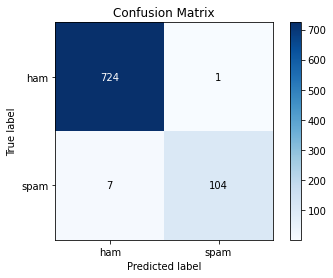

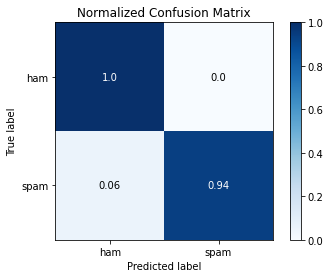

In [108]:
confusion_matrix_SVM = confusion_matrix(y_test,prediction,labels=["ham","spam"] )
skplt.metrics.plot_confusion_matrix(y_test,prediction, normalize=False)
skplt.metrics.plot_confusion_matrix(y_test,prediction, normalize=True)

print('confusion_matrix_SVM: ', confusion_matrix_SVM)
plt.show()

In [114]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       727
        spam       1.00      0.86      0.93       109

    accuracy                           0.98       836
   macro avg       0.99      0.93      0.96       836
weighted avg       0.98      0.98      0.98       836



In [115]:
# using Random forest calssifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()


In [116]:
model.fit(X_train, y_train)

prediction = model.predict(X_test)
accuracy_score(y_test, prediction)

0.9760765550239234

confusion_matrix_SVM:  [[727   0]
 [ 20  89]]


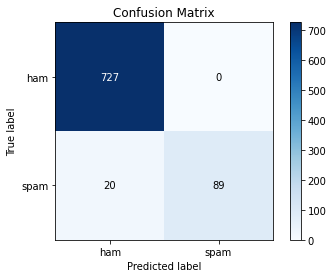

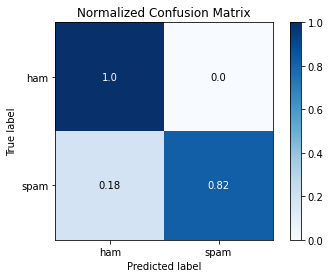

In [117]:
confusion_matrix_SVM = confusion_matrix(y_test,prediction,labels=["ham","spam"] )
skplt.metrics.plot_confusion_matrix(y_test,prediction, normalize=False)
skplt.metrics.plot_confusion_matrix(y_test,prediction, normalize=True)

print('confusion_matrix_SVM: ', confusion_matrix_SVM)
plt.show()

In [119]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       727
        spam       1.00      0.82      0.90       109

    accuracy                           0.98       836
   macro avg       0.99      0.91      0.94       836
weighted avg       0.98      0.98      0.98       836



In [ ]:
#Reference for below implementation - https://kgptalkie.com/nlp-tutorial

In [127]:
df_2 = df.iloc[:,0:2]

In [128]:
df_2.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [129]:
ham = df_2[df_2['v1']=='ham']

In [130]:
ham.shape

(4825, 2)

In [131]:
spam = df_2[df_2['v1']=='spam']

In [132]:
spam.shape

(747, 2)

In [97]:
# ham labels are greater in number than spam labels. Hence choosing random ham samples equal to number of spam samples

In [133]:
ham = ham.sample(spam.shape[0])

In [134]:
spam.shape

(747, 2)

In [135]:
ham.shape

(747, 2)

In [136]:
# Adding spam and ham labels to dataframe
data_2 = ham.append(spam, ignore_index=True)

In [137]:
data_2.head()

,v1,v2
0,ham,LOL what happens in Vegas stays in vegas
1,ham,Can i get your opinion on something first?
2,ham,"Sweetheart, hope you are not having that kind ..."
3,ham,That's necessarily respectful
4,ham,Dude got a haircut. Now its breezy up there


In [138]:
text_2 = data_2['v2']


In [139]:
#Tokenizing words
messages=[]
for i in range(data_2.shape[0]):
    text1=word_tokenize(text_2[i])
    messages =text1+messages

In [140]:
#convert text data to word embeddings using Word2vec
model_2 = gensim.models.Word2Vec(messages, size=100, workers=4, min_count=1)

In [141]:
words_2 =list(model_2.wv.vocab)


In [ ]:
#After converting each word to vector (embedding) take average of all word vectors to obtain vector for message 
# this is final feature vector for message

In [142]:
def word_2_vec(x):
    t1=word_tokenize(x)
    model_2[t1]
    v=list(map(lambda y: sum(y)/len(y), zip(*model_2[t1])))
    a=np.array(v)
    return a.reshape(1,-1)

In [ ]:
#Applying word2vec to each text message

In [ ]:
data_2['vec']=data_2['v2'].apply(lambda x: word_2_vec(x))

In [82]:
data_2.head()

,v1,v2,vec
0,ham,Send his number and give reply tomorrow mornin...,"[[0.018334430416871328, -0.023080198327887855,..."
1,ham,Then why you not responding,"[[0.010720941575709731, -0.013036874152021483,..."
2,ham,Hi mate its RV did u hav a nice hol just a mes...,"[[0.015456565684519686, -0.01820593677187008, ..."
3,ham,"Hi hope u get this txt~journey hasnt been gd,n...","[[0.02273194753959413, -0.027969391810377903, ..."
4,ham,U're welcome... Caught u using broken english ...,"[[0.008403663136877267, -0.009820819091559812,..."


In [ ]:
#Converting each feature vector into dataframe

In [83]:
w_vec=np.concatenate(data_2['vec'].to_numpy(), axis=0)

In [84]:
word_vec_df=pd.DataFrame(w_vec)

In [85]:
word_vec_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.018334,-0.023080,0.024694,0.011517,0.000799,0.008874,-0.020987,-0.006058,0.029769,-0.011209,0.004067,-0.007297,0.009524,-0.000980,0.020065,0.017235,0.014922,-0.028971,0.004684,0.010424,-0.020704,-0.018246,0.010459,-0.005632,0.003842,0.028545,0.006994,-0.009444,-0.015444,-0.015670,-0.016128,0.001351,0.008183,0.031153,0.005435,-0.002942,0.010080,-0.014864,0.001886,-0.005087,...,-0.000853,-0.024347,-0.013055,-0.021227,-0.007817,-0.009629,-0.008063,0.010862,0.029744,0.007734,0.027581,0.026880,-0.017241,-0.000875,-0.001896,0.007728,-0.008628,-0.008625,-0.016590,0.008577,0.013996,0.012590,0.002796,0.021536,0.009059,-0.008996,0.016909,0.015685,-0.018266,-0.003526,0.014797,-0.016230,0.002484,-0.003261,0.015706,0.006945,-0.009809,0.006773,0.031186,0.009190
1,0.010721,-0.013037,0.018563,0.009379,-0.000254,0.005794,-0.015788,-0.005305,0.016132,-0.008542,0.000714,-0.005054,0.006517,0.001032,0.011397,0.013565,0.009991,-0.019484,0.001507,0.005126,-0.015212,-0.010616,0.006406,-0.003627,0.003945,0.015873,0.003891,-0.006575,-0.011441,-0.009620,-0.009988,0.001478,0.004160,0.018612,0.000863,-0.003586,0.005725,-0.007537,0.002943,-0.003511,...,0.001491,-0.017379,-0.006125,-0.014741,-0.002292,-0.007566,-0.007474,0.006089,0.020471,0.005607,0.018976,0.017802,-0.011577,-0.002068,-0.001427,0.007626,-0.006495,-0.006039,-0.010394,0.006487,0.009370,0.009469,0.002578,0.014414,0.005934,-0.004405,0.010986,0.010803,-0.014248,-0.001528,0.008296,-0.010471,0.000786,-0.002972,0.008847,0.003678,-0.005166,0.005201,0.021364,0.005313
2,0.015457,-0.018206,0.018770,0.009288,0.000951,0.007158,-0.017480,-0.003909,0.022212,-0.009178,0.003666,-0.005555,0.007611,0.000051,0.016083,0.014476,0.011231,-0.022520,0.003258,0.009736,-0.016480,-0.015307,0.007342,-0.002005,0.003029,0.022616,0.005000,-0.007491,-0.013279,-0.011928,-0.012403,0.001463,0.006353,0.023606,0.003331,-0.002120,0.008573,-0.011530,0.001431,-0.004900,...,-0.000406,-0.019821,-0.009553,-0.017241,-0.006000,-0.007548,-0.006336,0.007943,0.023912,0.006949,0.022453,0.020503,-0.014027,-0.000534,-0.001658,0.005794,-0.007671,-0.007414,-0.011388,0.005844,0.010630,0.009147,0.002469,0.017289,0.006739,-0.005703,0.013144,0.013653,-0.014712,-0.002318,0.012886,-0.011920,0.001115,-0.002848,0.011571,0.005692,-0.008501,0.006525,0.025360,0.007528
3,0.022732,-0.027969,0.026953,0.013029,0.000721,0.010410,-0.025560,-0.005777,0.033048,-0.013894,0.004342,-0.007645,0.009747,0.000271,0.023469,0.021778,0.016715,-0.031988,0.005521,0.012449,-0.024711,-0.022278,0.012343,-0.004180,0.003713,0.033317,0.008764,-0.011685,-0.017278,-0.018327,-0.017887,0.003521,0.009540,0.034823,0.004676,-0.004020,0.011786,-0.016676,0.001761,-0.006519,...,-0.000865,-0.027728,-0.014087,-0.025365,-0.009184,-0.010833,-0.008578,0.010346,0.035254,0.010735,0.030459,0.029417,-0.020566,-0.000163,-0.002852,0.007342,-0.010540,-0.010527,-0.017978,0.008475,0.015222,0.013337,0.004133,0.023874,0.009734,-0.009959,0.020644,0.019079,-0.021462,-0.004572,0.018612,-0.019323,0.002134,-0.004908,0.016591,0.008501,-0.011274,0.008394,0.037196,0.009824
4,0.008404,-0.009821,0.008266,0.003288,0.001131,0.003189,-0.007892,-0.002754,0.010740,-0.003638,0.002375,-0.002617,0.001655,0.000294,0.006826,0.007638,0.006004,-0.010418,0.001702,0.003073,-0.007725,-0.007369,0.003412,-0.000784,0.000826,0.011832,0.000909,-0.004285,-0.007107,-0.006740,-0.005376,0.001421,0.002789,0.010667,0.000484,-0.001736,0.003747,-0.003665,0.000090,-0.002540,...,-0.000533,-0.008906,-0.005271,-0.007257,-0.003965,-0.004675,-0.001534,0.003508,0.012162,0.003406,0.010705,0.010433,-0.006268,0.000067,-0.002918,0.001795,-0.004708,-0.003384,-0.005441,0.003192,0.007310,0.003727,0.001989,0.008346,0.002214,-0.004043,0.007330,0.006408,-0.007697,-0.002565,0.006992,-0.005901,0.000523,-0.001885,0.004044,0.0035

In [86]:
X_train, X_test, y_train, y_test = train_test_split(word_vec, data_2['v1'], test_size = 0.2, random_state=3, shuffle = True, stratify=data_2['v1'])
# Startify labels to ensure equal distribution in training and testing datsets

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)
accuracy_score(y_pred,y_test)
# It can be observed that accuracy of model is 82.27%

0.822742474916388